In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import pypsa

In [2]:
dfa = pd.read_excel('../data/ETYS Appendix B 2022.xlsx', sheet_name='B-2-1a', skiprows=1)
dfb = pd.read_excel('../data/ETYS Appendix B 2022.xlsx', sheet_name='B-2-1b', skiprows=1)
dfc = pd.read_excel('../data/ETYS Appendix B 2022.xlsx', sheet_name='B-2-1c', skiprows=1)
dfd = pd.read_excel('../data/ETYS Appendix B 2022.xlsx', sheet_name='B-2-1d', skiprows=1)
dfa['component'] = 'line'
dfa['carrier'] = 'AC'
dfb['component'] = 'line'
dfb['carrier'] = 'AC'
dfc['component'] = 'line'
dfc['carrier'] = 'AC'
dfd['component'] = 'line'
dfd['carrier'] = 'AC'
dfe = pd.read_excel('../data/ETYS Appendix B 2022.xlsx', sheet_name='B-3-1a', skiprows=1)
dff = pd.read_excel('../data/ETYS Appendix B 2022.xlsx', sheet_name='B-3-1b', skiprows=1)
dff.rename(columns={'Node1': 'Node 1', 'Node2': 'Node 2'}, inplace=True)
dfg = pd.read_excel('../data/ETYS Appendix B 2022.xlsx', sheet_name='B-3-1c', skiprows=1)
dfg.rename(columns={'Node1': 'Node 1', 'Node2': 'Node 2'}, inplace=True)
dfh = pd.read_excel('../data/ETYS Appendix B 2022.xlsx', sheet_name='B-3-1d', skiprows=1)
dfe['component'] = 'transformer'
dfe['carrier'] = 'AC'
dff['component'] = 'transformer'
dff['carrier'] = 'AC'
dfg['component'] = 'transformer'
dfg['carrier'] = 'AC'
dfh['component'] = 'transformer'
dfh['carrier'] = 'AC'
dfi = pd.read_excel('../data/ETYS Appendix B 2022.xlsx', sheet_name='B-5-1', skiprows=1)
# filter out only those with existing in Existing column
dfi = dfi[dfi['Existing'] == 'Yes']
dfi['component'] = 'link'
dfi['carrier'] = 'DC'

dfj = pd.read_excel('../data/GB_network.xlsx', sheet_name='Extra_WF_edges')
dfj['component'] = 'line'
dfj['carrier'] = 'AC'

df = pd.concat([dfa, dfb, dfc, dfd, dfe, dff, dfg, dfh, dfi, dfj], ignore_index=True)
df.rename(columns={'Node 1': 'bus0', 'Node 2': 'bus1'}, inplace=True)
df.index.name = 'name'
df.reset_index(drop=True, inplace=True)
# remove lines with Winter Rating (MVA) = 9999
# df = df[df['Winter Rating (MVA)'] != 9999]
# replace any node called Central DC Substation with BLHI4-
# df['bus0'] = df['bus0'].str.replace('Central DC Substation', 'BLHI4-')
# df['bus1'] = df['bus1'].str.replace('Central DC Substation', 'BLHI4-')
# get line data in pypsa format
df.rename(columns={'R (% on 100 MVA)': 'r', 'X (% on 100 MVA)': 'x', 'B (% on 100 MVA)': 'b', 'Winter Rating (MVA)': 's_nom'}, inplace=True)
# remove unneeded columns for pypsa
df = df[['component', 'carrier', 'bus0', 'bus1', 'r', 'x', 'b', 's_nom']]
# n.lines = n.lines.drop(columns=['OHL Length (km)', 'Cable Length (km)', 'Circuit Type', 'Spring Rating (MVA)'])
df

,component,carrier,bus0,bus1,r,x,b,s_nom
0,line,AC,ABBA1-,DYCE1J,0.1092,1.2324,10.140,173.0
1,line,AC,ABNE1Q,ABNE1R,0.0100,0.0100,0.000,9999.0
2,line,AC,ABNE1Q,CHAR1-,2.4900,5.6600,1.220,132.0
3,line,AC,ABNE1R,AMUL1G,2.8706,6.5818,1.397,132.0
4,line,AC,ACHR1R,INVE1J,0.3387,3.9588,1.291,739.0
...,...,...,...,...,...,...,...,...
2944,line,AC,THAW11,RICH41,NaN,NaN,NaN,NaN
2945,line,AC,THAW12,RICH41,NaN,NaN,NaN,NaN
2946,line,AC,WAAO11,HEYS41,NaN,NaN,NaN,NaN
2947,line,AC,WABO11,STAH11,NaN,NaN,NaN,NaN


In [3]:
# buses from line data
df_buses = pd.concat([df['bus0'], df['bus1']]).unique()
df_buses = pd.DataFrame(df_buses, columns=['name'])
df_buses.index = df_buses['name']
df_buses.index.name = 'name'
df_buses

,name
name,
ABBA1-,ABBA1-
ABNE1Q,ABNE1Q
ABNE1R,ABNE1R
ACHR1R,ACHR1R
AIGA1Q,AIGA1Q
...,...
WERW32,WERW32
Central DC Substation,Central DC Substation
LONO41,LONO41


In [4]:
voltage_data = {'1': 132, '2': 275, '3': 33, '4': 400, '5': 11, '6': 66, '7': 20.5}
# extract first character of string which is a number from df_buses name column
map = df_buses['name'].str.extract('(\d+)', expand=False)
# remove all apart from the first character of the string
map = map.str[0]
# use this map to add voltage data to df_buses
df_buses['v_nom'] = map.map(voltage_data)
df_buses

,name,v_nom
name,,
ABBA1-,ABBA1-,132.0
ABNE1Q,ABNE1Q,132.0
ABNE1R,ABNE1R,132.0
ACHR1R,ACHR1R,132.0
AIGA1Q,AIGA1Q,132.0
...,...,...
WERW32,WERW32,33.0
Central DC Substation,Central DC Substation,NaN
LONO41,LONO41,400.0


In [5]:
# create a new dataframe from df with the bus0 and bus1 columns and carrier column
df_carrier = df[['bus0', 'bus1', 'carrier']]
df_carrier2 = df_carrier.copy()
# make bus0 index, while dropping column
df_carrier = df_carrier.set_index('bus0', drop=True)
# drop bus 1 column
df_carrier = df_carrier.drop(columns=['bus1'])

df_carrier2 = df_carrier2.set_index('bus1', drop=True)
# drop bus 0 column
df_carrier2 = df_carrier2.drop(columns=['bus0'])
# set both index names to name
df_carrier.index.name = 'name'
df_carrier2.index.name = 'name'
# concat dfs
df_carrier = pd.concat([df_carrier, df_carrier2])
# drop duplicates
df_carrier = df_carrier[~df_carrier.index.duplicated(keep='first')]
# add carrier column to df_buses
df_buses['carrier'] = df_buses.index.map(df_carrier['carrier'])
df_buses

,name,v_nom,carrier
name,,,
ABBA1-,ABBA1-,132.0,AC
ABNE1Q,ABNE1Q,132.0,AC
ABNE1R,ABNE1R,132.0,AC
ACHR1R,ACHR1R,132.0,AC
AIGA1Q,AIGA1Q,132.0,AC
...,...,...,...
WERW32,WERW32,33.0,AC
Central DC Substation,Central DC Substation,NaN,DC
LONO41,LONO41,400.0,AC


In [6]:
# FES data with GSP locations
df2 = pd.read_excel('../data/Regional breakdown of FES23 data (ETYS 2023 Appendix E).xlsb', sheet_name='GSP info', skiprows=4, index_col=1)
# df2.index = df2.index.str[:4]
df2 = df2[~df2.index.duplicated(keep='first')]
df2.rename(columns={'Latitude':'y', 'Longitude': 'x'}, inplace=True)
# df2.drop(['ROTI'], inplace=True)
df2.drop(columns=['Name'], inplace=True)
df2.index.name = 'name'
df2['name'] = df2.index
df2

,Unnamed: 0,GSP Group,Minor FLOP,y,x,Comments,name
name,,,,,,,
ABNE_P,NaN,_P,T4,56.339456,-3.293751,NaN,ABNE_P
ABTH_1,NaN,_K,H2,51.385210,-3.403318,NaN,ABTH_1
ABHA1,NaN,_L,F6,50.471559,-3.729489,NaN,ABHA1
ACTL_C,NaN,_C,A7,51.534951,-0.257050,NaN,ACTL_C
ACTL_2,NaN,_H,A7,51.534951,-0.257050,NaN,ACTL_2
...,...,...,...,...,...,...,...
G_EXTRA_8,NaN,_N,S6,55.646024,-4.793802,"GSP ""SACO"" modelled as 2 parts (split busbar)",G_EXTRA_8
G_EXTRA_9,NaN,_N,S6,55.646024,-4.793802,"GSP ""SACO"" modelled as 2 parts (split busbar)",G_EXTRA_9
G_EXTRA_10,NaN,_N,S6,55.821124,-4.364302,"GSP ""CROO"" modelled as 2 parts (split busbar)",G_EXTRA_10


In [7]:
# Step 1: Define a function that takes an index and returns the corresponding x and y values from `df2` where the first 4 characters of the index match.
def get_xy(index):
    matching_df2 = df2[df2.index.str[:4] == index[:4]]
    if not matching_df2.empty:
        return matching_df2.iloc[0]['x'], matching_df2.iloc[0]['y']
    else:
        return None, None

# Step 2: Apply this function to the index of `df_buses` to create the new columns.
df_buses['x'], df_buses['y'] = zip(*df_buses.index.map(get_xy))
df_buses = df_buses.fillna(np.nan)
df_buses

,name,v_nom,carrier,x,y
name,,,,,
ABBA1-,ABBA1-,132.0,AC,NaN,NaN
ABNE1Q,ABNE1Q,132.0,AC,-3.293751,56.339456
ABNE1R,ABNE1R,132.0,AC,-3.293751,56.339456
ACHR1R,ACHR1R,132.0,AC,NaN,NaN
AIGA1Q,AIGA1Q,132.0,AC,NaN,NaN
...,...,...,...,...,...
WERW32,WERW32,33.0,AC,NaN,NaN
Central DC Substation,Central DC Substation,NaN,DC,NaN,NaN
LONO41,LONO41,400.0,AC,NaN,NaN


In [8]:
# # add ETYS load data
# df_load = pd.read_excel('../data/ETYS23 Appendix G_1.xlsx', sheet_name='demand data 2022', skiprows=8)
# df_load = df_load.iloc[1:]
# df_load.index = df_load['Unnamed: 0']
# df_load.index.name = 'name'
# df_load = df_load[['23/24']]
# df_load.rename(columns={'23/24': 'p_set'}, inplace=True)
# df_load

In [9]:
network = pypsa.Network()
network.set_snapshots(range(1))
network.import_components_from_dataframe(df_buses, "Bus")
network.import_components_from_dataframe(df, "Line")

# network.import_components_from_dataframe(df3_load, "Load")
network.consistency_check()

Index(['701', '1058', '1059', '1060', '1219', '1220', '1222', '1223', '1240',
       '1241', '1347', '1348', '1349', '1350', '1364'],
      dtype='object', name='Line')
Index(['434', '582', '584', '647', '671', '672', '678', '701', '719', '726',
       '1058', '1059', '1060', '1074', '1075', '1078', '1079', '1101', '1102',
       '1133', '1134', '1178', '1219', '1220', '1222', '1223', '1240', '1241',
       '1285', '1286', '1313', '1347', '1348', '1349', '1350', '1364', '1365',
       '1366'],
      dtype='object', name='Line')


In [10]:
# guess the coordinates of buses with NaN coordinates

# Initialize the previous counts
prev_count_x = len(network.buses) + 1
prev_count_y = len(network.buses) + 1

while True:
    # Get the current counts
    curr_count_x = network.buses['x'].isna().sum()
    curr_count_y = network.buses['y'].isna().sum()

    # If neither count has changed, break the loop
    if prev_count_x == curr_count_x and prev_count_y == curr_count_y:
        break

    # Update the previous counts
    prev_count_x = curr_count_x
    prev_count_y = curr_count_y

    # Print the number of buses with NaN coordinates
    print(f"There are {curr_count_x + curr_count_y} buses with NaN coordinates.")
    
    # For each bus with NaN coordinates
    for bus in network.buses[network.buses['x'].isna() | network.buses['y'].isna()].index:
        # Find lines connected to this bus
        connected_lines = network.lines[(network.lines['bus0'] == bus) | (network.lines['bus1'] == bus)]
        # Get the buses at the ends of these lines
        connected_buses = network.buses.loc[pd.concat([connected_lines['bus0'], connected_lines['bus1']]).unique()]
        # Exclude the current bus
        connected_buses = connected_buses[connected_buses.index != bus]
        # If there are any connected buses with known coordinates
        if not connected_buses.dropna(subset=['x', 'y']).empty:
            # Estimate the coordinates of the current bus as the mean of the coordinates of the connected buses
            network.buses.loc[bus, ['x', 'y']] = connected_buses[['x', 'y']].mean()

# update df with new coordinates
df_buses_with_locs = network.buses
# remove name column
df_buses_with_locs = df_buses_with_locs.drop(columns=['name'])

# remove lines with NaN coordinates
# network.lines = network.lines[network.lines['bus0'].isin(network.buses.index) & network.lines['bus1'].isin(network.buses.index)]

There are 1826 buses with NaN coordinates.
There are 640 buses with NaN coordinates.
There are 118 buses with NaN coordinates.
There are 26 buses with NaN coordinates.
There are 0 buses with NaN coordinates.


In [11]:
# new network with updated locations of buses
network2 = pypsa.Network()
network2.set_snapshots(range(1))

network2.import_components_from_dataframe(df_buses_with_locs, "Bus")

# filter df with component of line
df_line = df[df['component'] == 'line']
df_line.to_csv('lines.csv')
network2.import_components_from_dataframe(df_line, "Line")

# filter df with component of transformer
df_transformer = df[df['component'] == 'transformer']
# drop s_nom column
df_transformer = df_transformer.drop(columns=['s_nom'])
# change name of Rating (MVA) to s_nom
df_transformer.rename(columns={'Rating (MVA)': 's_nom'}, inplace=True)
network2.import_components_from_dataframe(df_transformer, "Transformer")

# filter df with component of link
df_link = df[df['component'] == 'link']
# rename s_nom to p_nom
df_link.rename(columns={'s_nom': 'p_nom'}, inplace=True)
network2.import_components_from_dataframe(df_link, "Link")

# network2.import_components_from_dataframe(df_load, "Load")

C:\Users\alyden\AppData\Local\Temp\ipykernel_8840\250877476.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_link.rename(columns={'s_nom': 'p_nom'}, inplace=True)


Index(['701', '1058', '1059', '1060', '1219', '1220', '1222', '1223', '1240',
       '1241', '1347', '1348', '1349', '1350', '1364'],
      dtype='object', name='Line')
Index(['434', '582', '584', '647', '671', '672', '678', '701', '719', '726',
       '1058', '1059', '1060', '1074', '1075', '1078', '1079', '1101', '1102',
       '1133', '1134', '1178', '1219', '1220', '1222', '1223', '1240', '1241',
       '1285', '1286', '1313', '1347', '1348', '1349', '1350', '1364', '1365',
       '1366'],
      dtype='object', name='Line')
Index(['1478', '1479', '1480', '1481', '1482', '1483', '1484', '1485', '1486',
       '1487',
       ...
       '2912', '2913', '2914', '2915', '2916', '2917', '2918', '2919', '2920',
       '2921'],
      dtype='object', name='Transformer', length=1444)
c:\Users\alyden\AppData\Local\miniforge3\envs\pypsa-lmp\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will ha

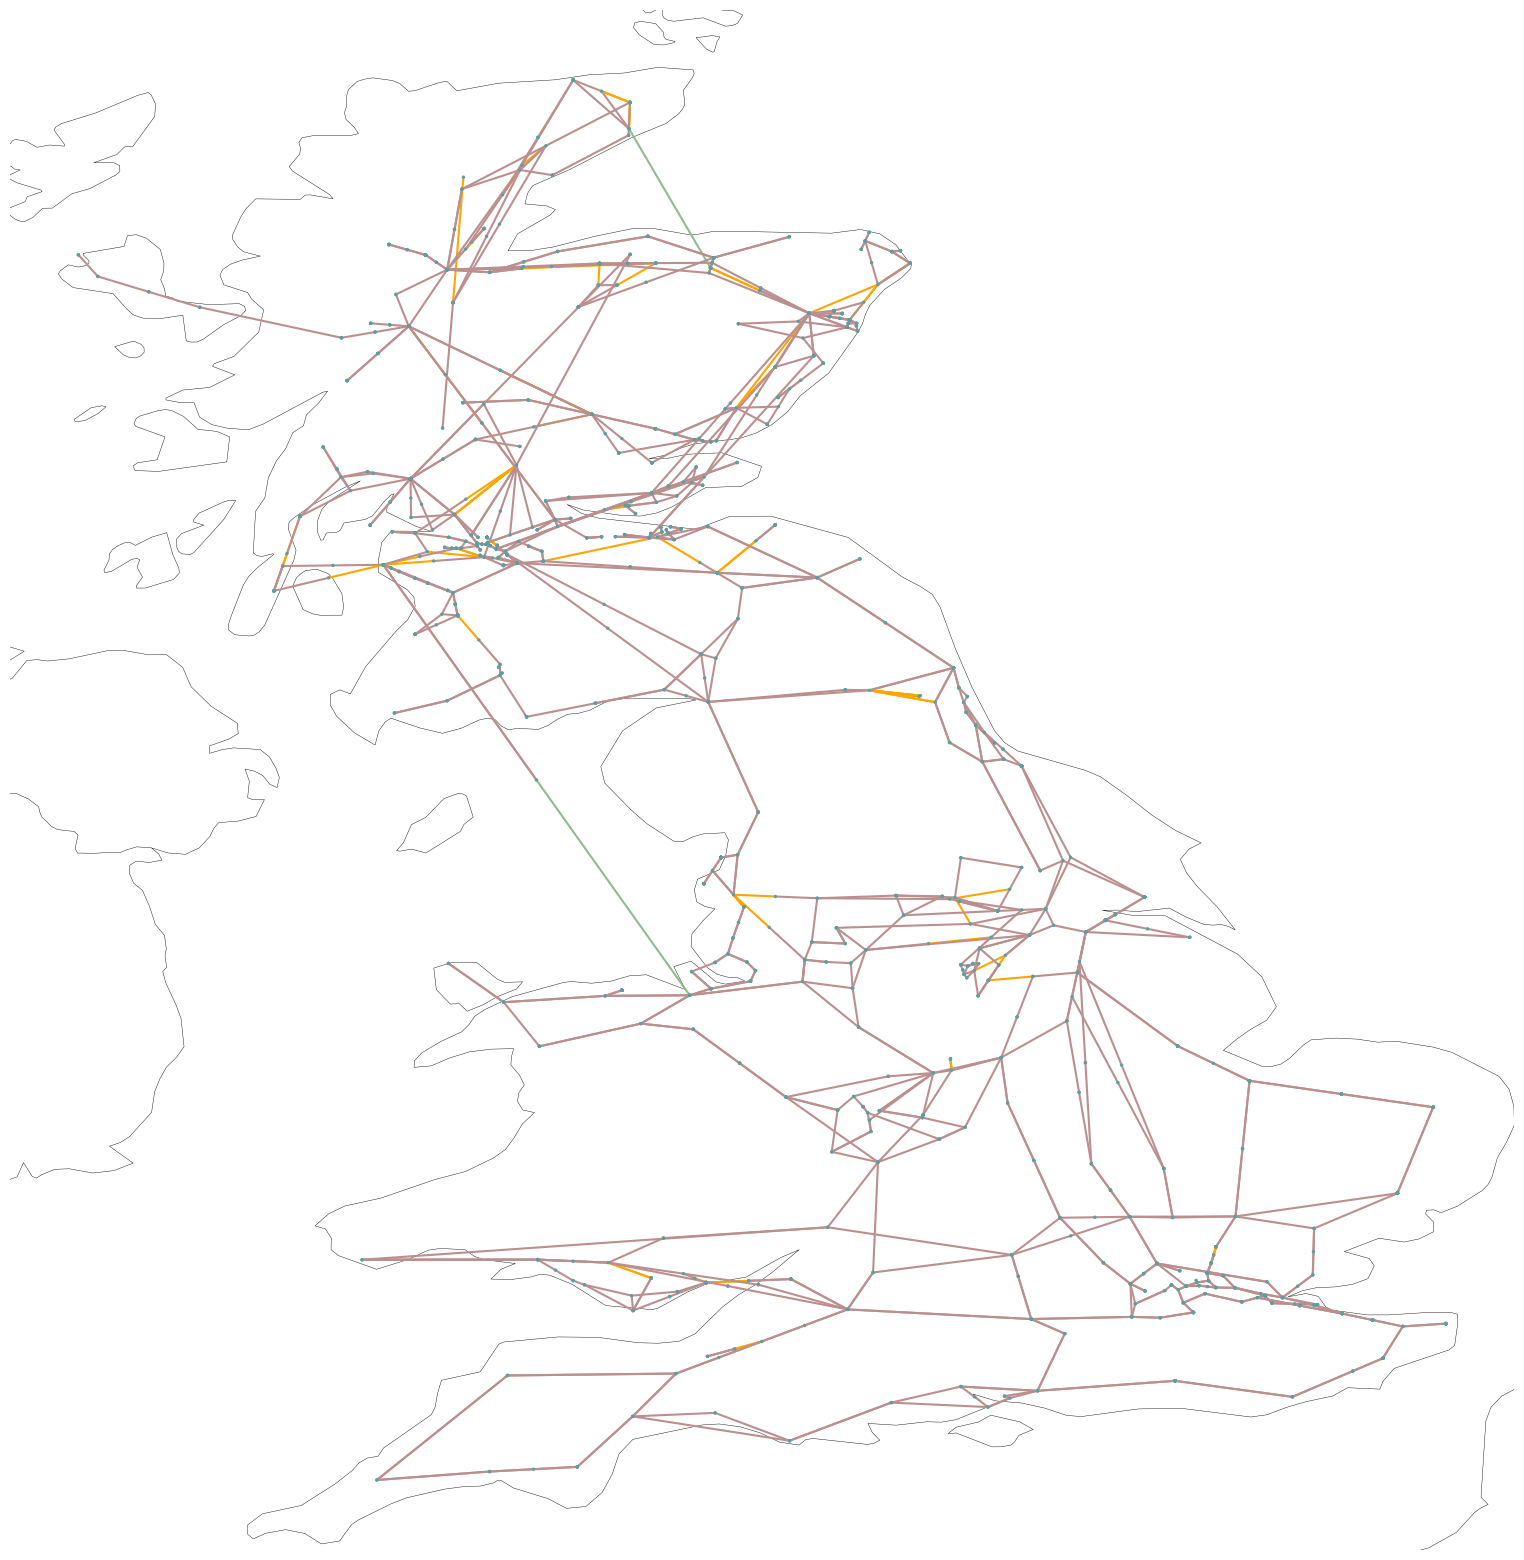

In [12]:
plt.rc("figure", figsize=(20, 20))
# Now you can plot the network
network2.plot(bus_sizes=0.0001)
network2.consistency_check()

In [13]:
import pypsa
import networkx as nx

# Assuming 'network' is your PyPSA network
graph = network2.graph()

# Find the connected components
connected_components = list(nx.connected_components(graph))

# The largest component is usually the main system
main_system = max(connected_components, key=len)

# print("Main system:", main_system)
print("Number of buses in the main system:", len(main_system))
# print("Buses:", network.buses.index)

# Find the buses not in the main system
isolated_buses = [bus for bus in network2.buses.index if bus not in main_system]

print("Isolated buses:", isolated_buses)
print("Number of isolated buses:", len(isolated_buses))

Number of buses in the main system: 1991
Isolated buses: []
Number of isolated buses: 0


(<matplotlib.collections.PatchCollection at 0x262ba7a8c10>,
 <matplotlib.collections.LineCollection at 0x262ba6e3d10>)

c:\Users\alyden\AppData\Local\miniforge3\envs\pypsa-lmp\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


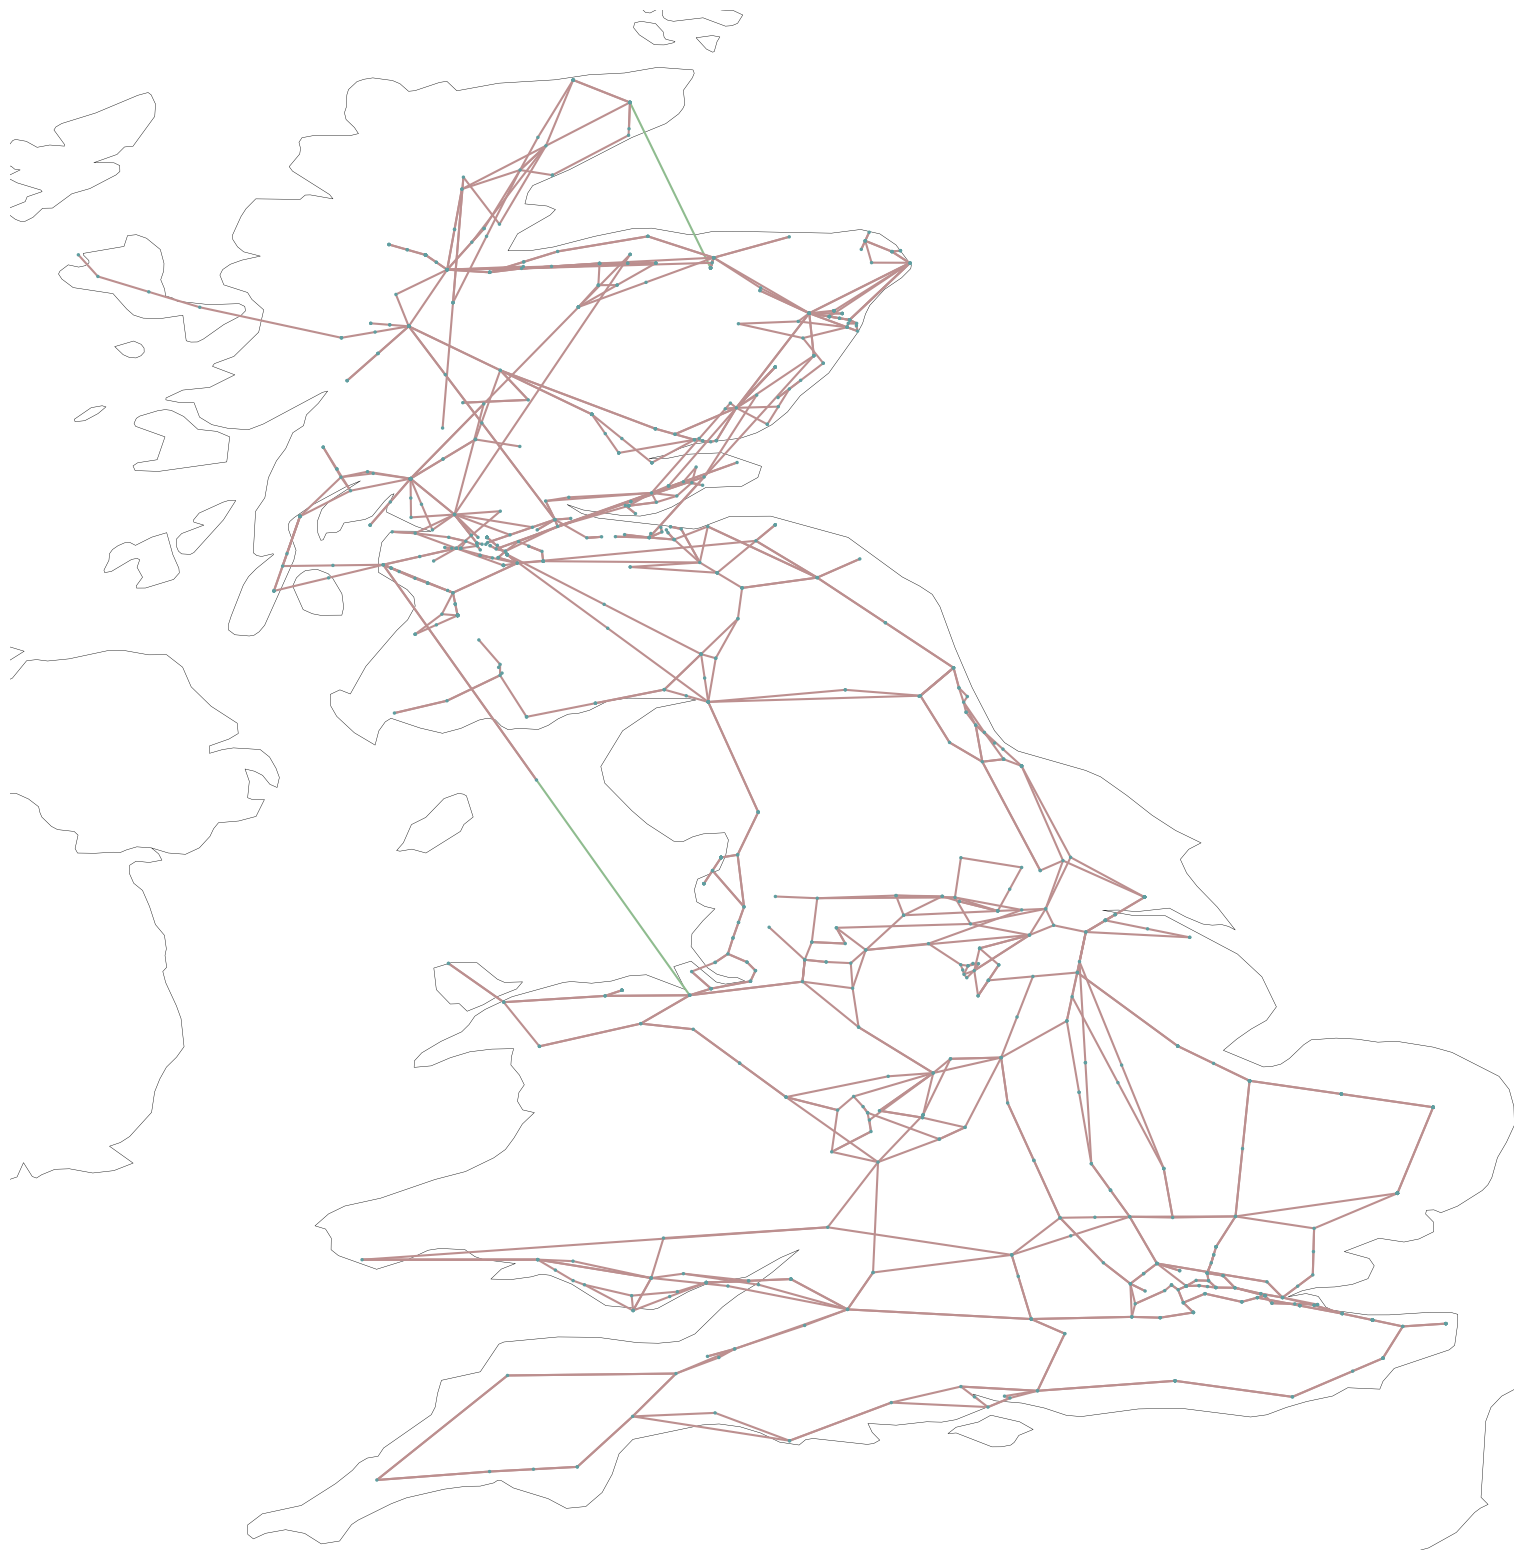

In [14]:
def simplify_network_to_400(n):
    """
    Fix all lines to a voltage level of 400 kV and remove all transformers.

    The function preserves the transmission capacity for each line while
    updating its voltage level, line type and number of parallel bundles
    (num_parallel).

    Transformers are removed and connected components are moved from
    their starting bus to their ending bus. The corresponding starting
    buses are removed as well.
    """
    # logger.info("Mapping all network lines onto a single 380kV layer")

    n.buses["v_nom"] = 400.0

    (linetype_400,) = n.lines.loc[n.lines.v_nom == 400.0, "type"].unique()
    n.lines["type"] = linetype_400
    n.lines["v_nom"] = 400
    # n.lines["i_nom"] = n.line_types.i_nom[linetype_400]
    # n.lines["num_parallel"] = n.lines.eval("s_nom / (sqrt(3) * v_nom * i_nom)")

    trafo_map = pd.Series(n.transformers.bus1.values, n.transformers.bus0.values)
    trafo_map = trafo_map[~trafo_map.index.duplicated(keep="first")]
    several_trafo_b = trafo_map.isin(trafo_map.index)
    trafo_map[several_trafo_b] = trafo_map[several_trafo_b].map(trafo_map)
    missing_buses_i = n.buses.index.difference(trafo_map.index)
    missing = pd.Series(missing_buses_i, missing_buses_i)
    trafo_map = pd.concat([trafo_map, missing])

    for c in n.one_port_components | n.branch_components:
        df = n.df(c)
        for col in df.columns:
            if col.startswith("bus"):
                df[col] = df[col].map(trafo_map)

    n.mremove("Transformer", n.transformers.index)
    n.mremove("Bus", n.buses.index.difference(trafo_map))

    return n, trafo_map

n, trafo_map = simplify_network_to_400(network2)
n.plot(bus_sizes=0.0001)

(<matplotlib.collections.PatchCollection at 0x262d40f5cd0>,
 <matplotlib.collections.LineCollection at 0x262d279b8d0>)

c:\Users\alyden\AppData\Local\miniforge3\envs\pypsa-lmp\Lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


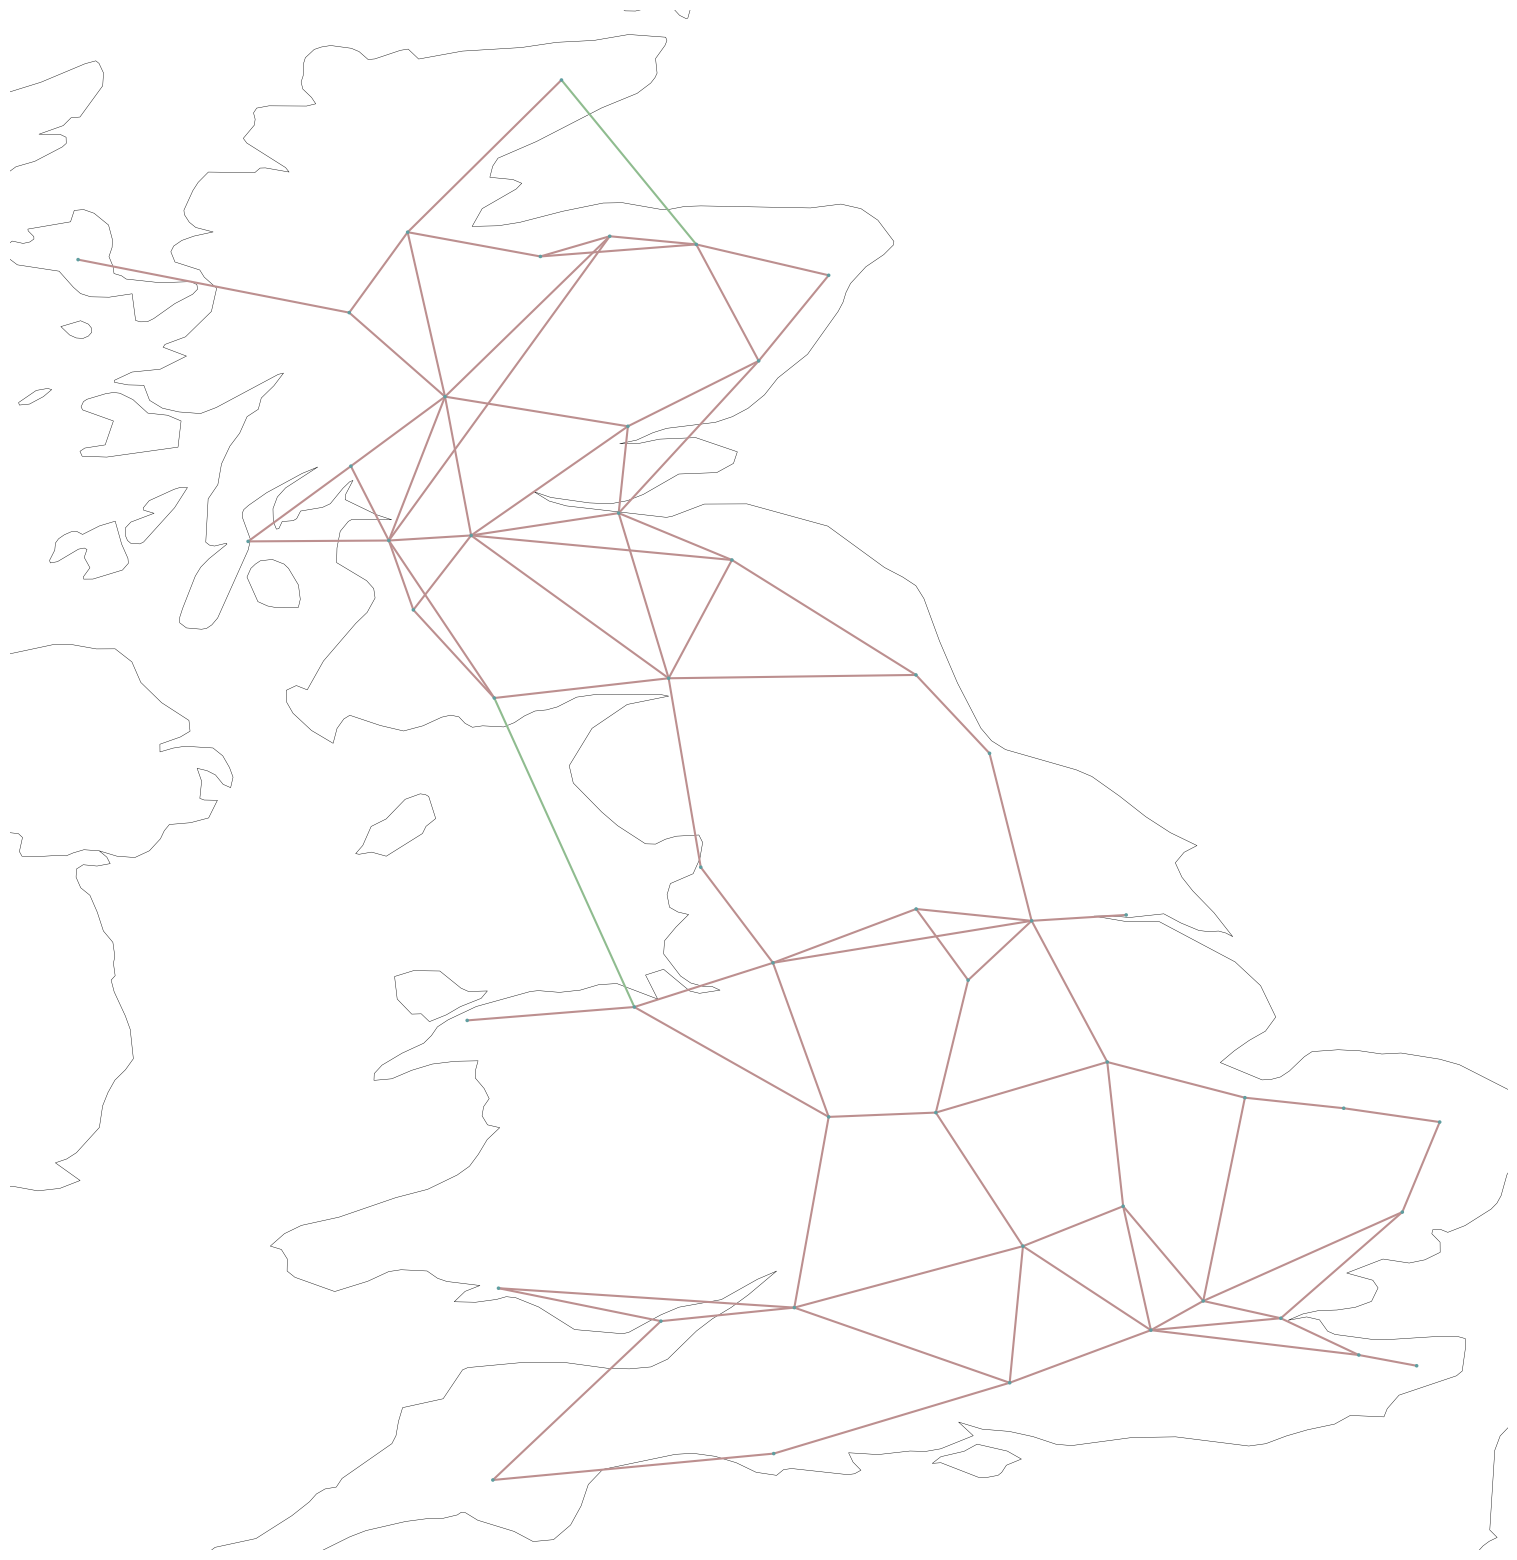

In [21]:
# set carrier same for buses
n.buses['carrier'] = 'AC'
weighting = pd.Series(1, n.buses.index)
busmap2 = n.cluster.busmap_by_kmeans(bus_weightings=weighting, n_clusters=50)
nc2 = n.cluster.cluster_by_busmap(busmap2)
nc2.plot(bus_sizes=0.0001)